In [4]:
%matplotlib inline

import matplotlib.pyplot as plt

import os
import numpy as np
from os.path import join, splitext
from scipy.spatial import distance
from astropy.io import fits
from itertools import product

import lsst.pex.config as pexConfig
import lsst.pipe.base as pipeBase
from lsst.obs.lsst import LsstCamMapper as camMapper
from lsst.obs.lsst.cameraTransforms import LsstCameraTransforms

from mixcoatl.sourcegrid import SourceGrid, coordinate_distances

In [5]:
camera = camMapper._makeCamera()
lct = LsstCameraTransforms(camera)

class SourceGridConfig(pexConfig.Config):
    """Configuration for GridFitTask."""

    max_displacement = pexConfig.Field("Maximum distance (pixels) between matched sources.",
                                       float, default=10.)
    nrows = pexConfig.Field("Number of grid rows.", int, default=49)
    ncols = pexConfig.Field("Number of grid columns.", int, default=49)
    output_dir = pexConfig.Field("Output directory", str, default=".")

class SourceGridTask(pipeBase.Task):
    """Task to perform source grid fit."""
    ConfigClass = SourceGridConfig
    _DefaultName = "SourceGridTask"

    @pipeBase.timeMethod
    def run(self, infile):

        ## Below needs to be hand tuned for now!
        basename = os.path.basename(infile)
        projector_y = float(basename.split('_')[-1][:-5]) # these are camera x/y coords
        projector_x = float(basename.split('_')[-2][:-1])

        ccd_name, ccd_x, ccd_y = lct.focalMmToCcdPixel(projector_y, projector_x)

        x0_guess = 8.*509. - ccd_x # Fix with ITL vs. E2V geometry?
        y0_guess = ccd_y
        print(x0_guess, y0_guess)
        ## above needs to be hand tuned for now!

        src = fits.getdata(infile)
        model_grid = SourceGrid.from_source_catalog(src, y0_guess=y0_guess, x0_guess=x0_guess)
        nrows = self.config.nrows
        ncols = self.config.ncols
        gY, gX = model_grid.make_grid(nrows=nrows, ncols=ncols)

        srcX = src['base_SdssShape_x']
        srcY = src['base_SdssShape_y']
        srcXX = src['base_SdssShape_xx']
        srcYY = src['base_SdssShape_yy'] 
        srcF = src['base_SdssShape_instFlux']

        indices, distances = coordinate_distances(gY, gX, srcY, srcX)
        nn_indices = indices[:, 0]

        data = {}
        data['DX'] = srcX[nn_indices]-gX
        data['DY'] = srcY[nn_indices]-gY
        data['DXX'] = srcXX[nn_indices]
        data['DYY'] = srcYY[nn_indices]
        data['FLUX'] = srcF[nn_indices]
        data['X'] = gX
        data['Y'] = gY
        data['XX'] = np.zeros(gX.shape[0])
        data['YY'] = np.zeros(gY.shape[0])

#        grid_displacements = GridDistortions(model_grid, nrows, ncols, data)
#        grid_displacements.mask_entries(self.config.max_displacement)

#        outfile = join(self.config.output_dir, 
#                       '{0}_displacement_results.fits'.format(splitext(basename)[0]))
#        grid_displacements.write_fits(outfile, overwrite=True)
        
        return model_grid

1835.5 2170.5
1832.927404122201 2149.835642045309


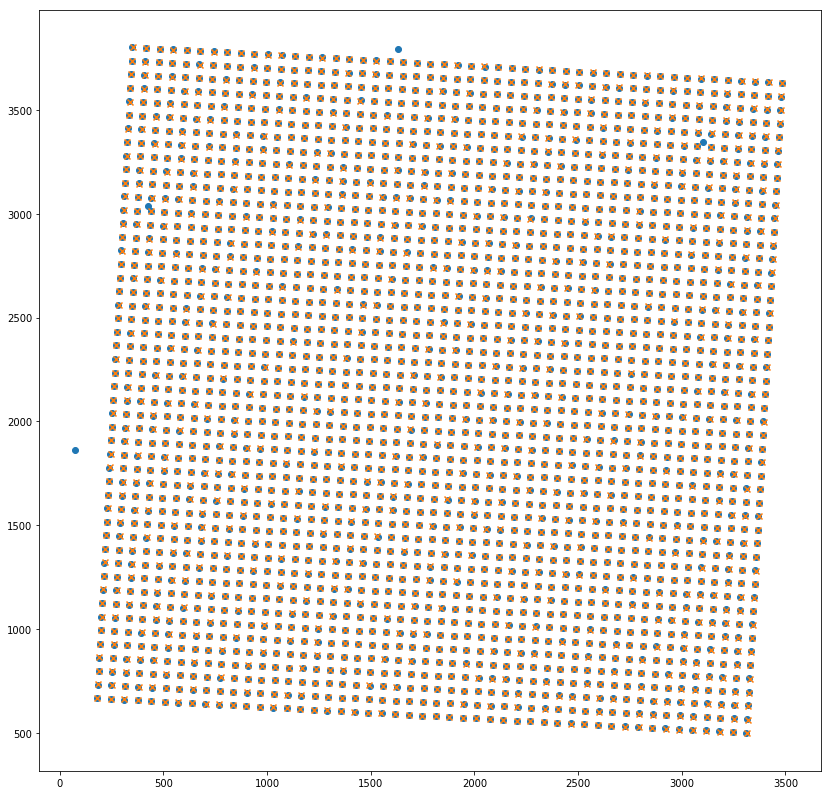

In [6]:
test_cat = '/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/BOT/6864D_dither/catalogs/MC_C_20191030_001924_R22_S11_15.0s_1.7x_2.0y.cat'

src = fits.getdata(test_cat)
srcY = src['base_SdssShape_y']
srcX = src['base_SdssShape_x']

gridtask = SourceGridTask()
model_grid = gridtask.run(test_cat)
print(model_grid.x0, model_grid.y0)

fig, ax = plt.subplots(1, 1, figsize=(14, 14))
ax.scatter(srcX, srcY, marker='o')

gY, gX = model_grid.make_grid(nrows=49, ncols=49)
        
ax.scatter(gX, gY, marker='x')